# Australian Wildfire Analysis with Data Visualization & Dashboard
---
## Overview
This project explores wildfire activity across Australia using historical satellite-based fire detection data. The goal is to uncover trends, spatial patterns, and regional differences in fire behavior through a combination of visual analysis and interactive dashboarding.

## Dataset Description
The dataset includes fire-related measurements such as estimated fire area, brightness, radiative power, and detection confidence across seven Australian regions, with data spanning from 2005 onward.

## Tools and Approach
The notebook focuses on exploratory data analysis (EDA) and static visualizations using `pandas`, `matplotlib`, `seaborn`, and `folium`, while an accompanying Dash app allows users to interactively explore monthly fire activity by region and year.

---


### Importing Libraries

All visualizations and analysis in this notebook are built using Python libraries such as pandas, seaborn, matplotlib, and folium.


In [52]:
import numpy as np
import pandas as pd
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns
import folium

%matplotlib inline

sns.set(style="whitegrid")

### Importing Data

In [53]:
url = "../data/wildfire_data.csv"
df = pd.read_csv(url)
print(f"Data loaded successfully with {df.shape[0]:,} rows and {df.shape[1]} columns.")

Data loaded successfully with 26,406 rows and 10 columns.


### Initial Data Exploration

We begin by reviewing the structure and contents of the dataset to understand its dimensionality, column types, and potential data quality issues.

In [54]:
# Preview the first few rows
df.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Std_confidence,Var_confidence,Count,Replaced
0,NSW,1/4/2005,8.68000,312.266667,42.400000,78.666667,2.886751,8.333333,3,R
1,NSW,1/5/2005,16.61125,322.475000,62.362500,85.500000,8.088793,65.428571,8,R
2,NSW,1/6/2005,5.52000,325.266667,38.400000,78.333333,3.214550,10.333333,3,R
3,NSW,1/7/2005,6.26400,313.870000,33.800000,92.200000,7.529940,56.700000,5,R
4,NSW,1/8/2005,5.40000,337.383333,122.533333,91.000000,7.937254,63.000000,3,R


In [6]:
# Verifying column names, data types and non-null counts
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26406 entries, 0 to 26405
Data columns (total 10 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   Region                               26406 non-null  object 
 1   Date                                 26406 non-null  object 
 2   Estimated_fire_area                  26406 non-null  float64
 3   Mean_estimated_fire_brightness       26406 non-null  float64
 4   Mean_estimated_fire_radiative_power  26406 non-null  float64
 5   Mean_confidence                      26406 non-null  float64
 6   Std_confidence                       24199 non-null  float64
 7   Var_confidence                       24199 non-null  float64
 8   Count                                26406 non-null  int64  
 9   Replaced                             26406 non-null  object 
dtypes: float64(6), int64(1), object(3)
memory usage: 2.0+ MB


In [55]:
# Check for missing values
df.isnull().sum()

Region                                    0
Date                                      0
Estimated_fire_area                       0
Mean_estimated_fire_brightness            0
Mean_estimated_fire_radiative_power       0
Mean_confidence                           0
Std_confidence                         2207
Var_confidence                         2207
Count                                     0
Replaced                                  0
dtype: int64

### Feature Descriptions

| Column | Description |
|--------|-------------|
| `Region` | One of seven regions in Australia |
| `Date` | Date of observation |
| `Estimated_fire_area` | Estimated fire-affected area (km²) |
| `Mean_estimated_fire_brightness` | Avg fire brightness (Kelvin) |
| `Mean_estimated_fire_radiative_power` | Avg radiative power (Megawatts) |
| `Mean_confidence` | Mean confidence of fire detection (%) |
| `Std_confidence` | Std deviation of fire confidence |
| `Var_confidence` | Variance of fire confidence |
| `Count` | Number of detected fire pixels |
| `Replaced` | Whether the data was replaced with higher-quality values |


## Data Cleaning and Preparation

### Handling Missing Values

To streamline the dataset for analysis, we dropped two columns (`Std_confidence` and `Var_confidence`) that contained missing values and were not required for our visualizations.

In [56]:
# Drop the two columns with missing values
df.drop(columns=['Std_confidence', 'Var_confidence'], inplace=True)

print(f"Remaining columns: {df.shape[1]} | Remaining rows: {df.shape[0]:,}")

Remaining columns: 8 | Remaining rows: 26,406


### Date Parsing and Temporal Features

The `Date` column, originally stored as an object, was converted to datetime format to support time-based analysis. From this, we extracted `Year` and `Month` as separate columns to simplify aggregation and filtering in both static visualizations and the interactive dashboard.

An additional `Month_Name` column was created to support clear labeling in visual outputs.

These features simplify grouping, filtering, and dashboard interactions.


In [57]:
# Convert 'Date' to datetime
df['Date'] = pd.to_datetime(df['Date'])

# Extract year and month from the Date column
df['Year'] = pd.to_datetime(df['Date']).dt.year
df['Month'] = pd.to_datetime(df['Date']).dt.month

# Add Month_Name Column
df['Month_Name'] = df['Date'].dt.strftime('%B')

month_order = ['January', 'February', 'March', 'April', 'May', 'June','July', 'August', 'September', 'October', 'November', 'December']

In [58]:
df.head()

,Region,Date,Estimated_fire_area,Mean_estimated_fire_brightness,Mean_estimated_fire_radiative_power,Mean_confidence,Count,Replaced,Year,Month,Month_Name
0,NSW,2005-01-04,8.68000,312.266667,42.400000,78.666667,3,R,2005,1,January
1,NSW,2005-01-05,16.61125,322.475000,62.362500,85.500000,8,R,2005,1,January
2,NSW,2005-01-06,5.52000,325.266667,38.400000,78.333333,3,R,2005,1,January
3,NSW,2005-01-07,6.26400,313.870000,33.800000,92.200000,5,R,2005,1,January
4,NSW,2005-01-08,5.40000,337.383333,122.533333,91.000000,3,R,2005,1,January


In [59]:
df.dtypes

Region                                         object
Date                                   datetime64[ns]
Estimated_fire_area                           float64
Mean_estimated_fire_brightness                float64
Mean_estimated_fire_radiative_power           float64
Mean_confidence                               float64
Count                                           int64
Replaced                                       object
Year                                            int32
Month                                           int32
Month_Name                                     object
dtype: object

## EDA with Data Visualization

This section explores key trends and patterns in wildfire activity using visual techniques such as line plots, bar charts, pie charts, and maps. Each visualization highlights different aspects of the dataset — from temporal trends to regional distributions.


### Average Fire Area by Year

To observe long-term changes in wildfire activity, we calculated the average estimated fire area for each year across all regions. This reveals how fire intensity may have shifted over time.

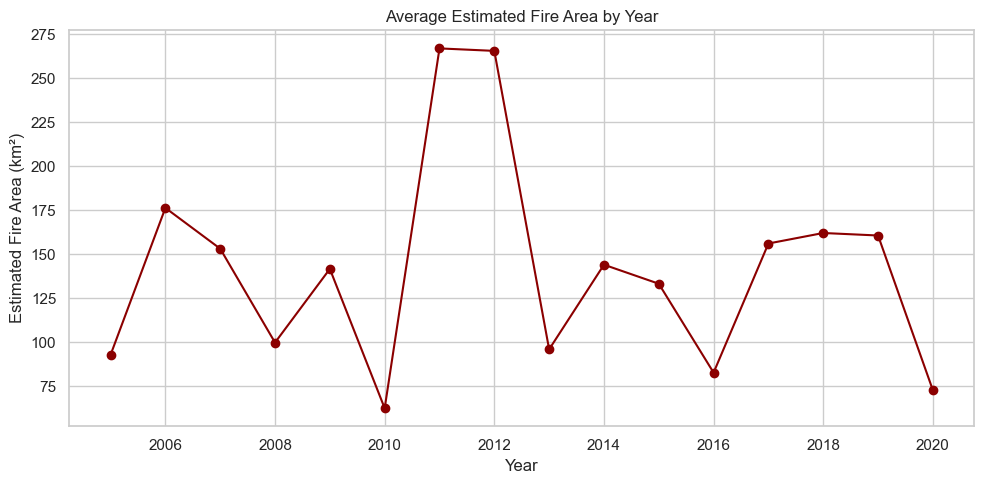

In [60]:

# Group by year and calculate average fire area
fire_area_trend = df.groupby('Year')['Estimated_fire_area'].mean()

# Plot the trend

plt.figure(figsize=(10,5))
fire_area_trend.plot(marker='o', color='darkred')
plt.title("Average Estimated Fire Area by Year")
plt.xlabel('Year')
plt.ylabel('Estimated Fire Area (km²)')
plt.grid(True)
plt.tight_layout()
plt.show()


As per the chart, the Wildfire activity peaked sharply in 2012, followed by a drop and moderate fluctuations in subsequent years. The trend suggests periodic surges in wildfire activity rather than a sustained trend.

### Monthly Fire Activity – Seasonal Patterns vs Historical Peaks

Wildfire activity in Australia is influenced by both seasonal climate patterns and year-specific environmental events. To explore this duality, we examine monthly trends in two complementary ways:

1. **Seasonal View (Month-Level Aggregation)**:  
   This chart shows the average fire area for each calendar month across all years, revealing overall seasonal patterns (e.g., summer fire peaks).

2. **Chronological View (Year-Month Time Series)**:  
   This chart maintains a continuous timeline, plotting fire activity month-by-month from 2005 onward. It highlights historic anomalies — like the sharp surge in 2012 — that would otherwise be flattened by averaging.

Together, these views provide a more complete picture of both recurring fire seasons and major wildfire events.


<details>
    <summary>Click here for a Hint</summary>
You will be required to group the year and month for 'Estimated_fire_area' (taking its mean)<br>Then use df.plot() on it to create a line graph

</details>


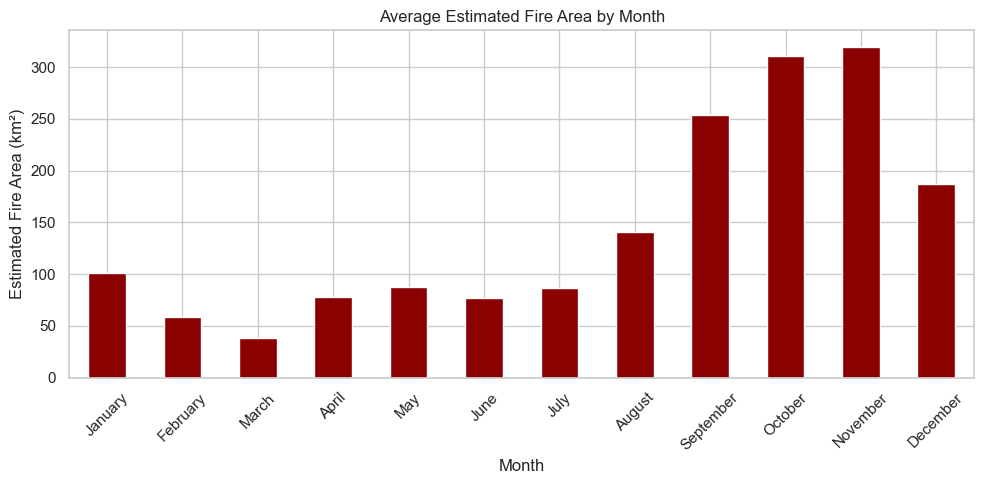

In [61]:
# Seasonal Trend View

# Group by Month_Name and calculate average fire area across all years
monthly_fire_area = df.groupby('Month_Name')['Estimated_fire_area'].mean()

# Ensure correct month order
month_order = ['January', 'February', 'March', 'April', 'May', 'June',
               'July', 'August', 'September', 'October', 'November', 'December']
monthly_fire_area = monthly_fire_area.reindex(month_order)

# Plot
plt.figure(figsize=(10, 5))
monthly_fire_area.plot(kind='bar', color='darkred')
plt.title('Average Estimated Fire Area by Month')
plt.xlabel('Month')
plt.ylabel('Estimated Fire Area (km²)')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


Wildfire activity increases steadily from August, peaking in October and November. Activity reaches its highest in **spring**, and starts tapering off by **December**. This aligns with Australia's fire season, which intensifies during the warmer, drier months of the year.

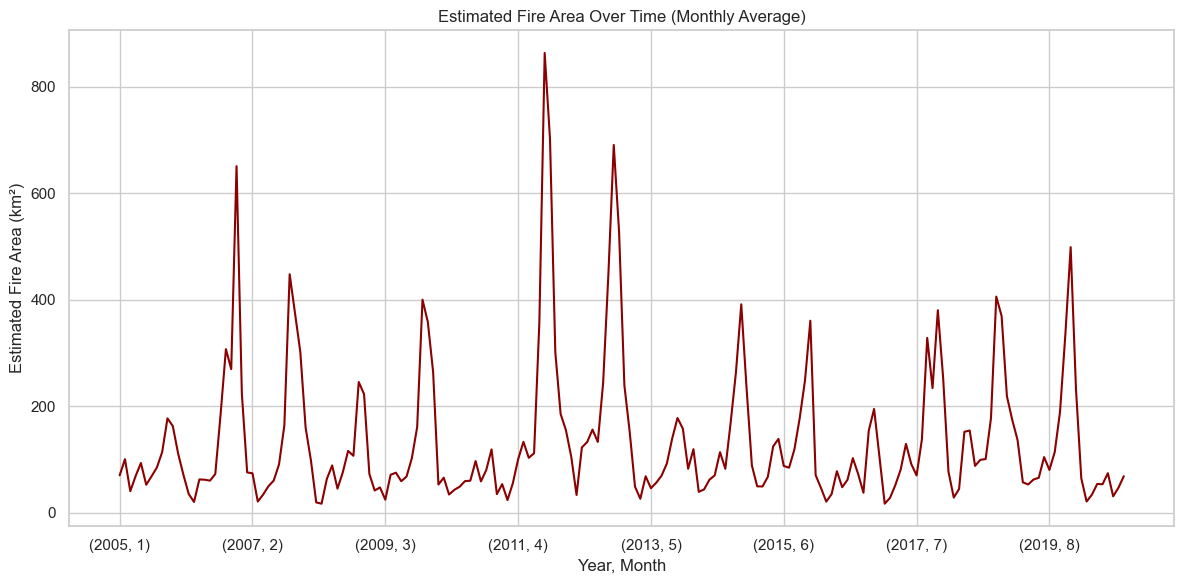

In [62]:
# Chronological Time Series

# Group by (Year, Month) and calculate average fire area
df_time_series = df.groupby(['Year', 'Month'])['Estimated_fire_area'].mean()


# Plot
plt.figure(figsize=(12, 6))
df_time_series.plot(color='darkred')
plt.title('Estimated Fire Area Over Time (Monthly Average)')
plt.xlabel('Year, Month')
plt.ylabel('Estimated Fire Area (km²)')
plt.grid(True)
plt.tight_layout()
plt.show()


The timeline shows clear spikes in wildfire activity during specific periods, with the most dramatic peak occurring between 2011 and 2013. This confirms the historical anomaly noted in earlier observations. While most years show cyclical seasonal surges, a few years — especially 2012 — stand out for unusually high fire area, likely due to extreme environmental conditions.


### Distribution of Detected Fire Pixels by Region

The chart below shows the proportion of fire pixels detected in each region across the full dataset. This gives a high-level view of which areas experience the most frequent fire activity, based on the number of high-confidence detections.


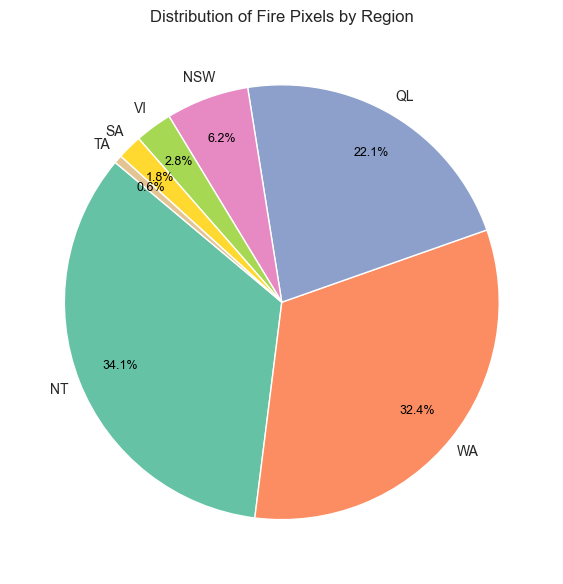

In [67]:

# Data setup
region_counts = df.groupby('Region')['Count'].sum().sort_values(ascending=False)
colors = sns.color_palette("Set2", n_colors=len(region_counts))

# Pie chart
fig, ax = plt.subplots(figsize=(6, 6))
wedges, texts, autotexts = ax.pie(
    region_counts,
    labels=region_counts.index,
    autopct='%1.1f%%',
    startangle=140,
    colors=colors,
    wedgeprops={'linewidth': 1, 'edgecolor': 'white'},
    textprops={'fontsize': 10},
    pctdistance=0.8,     # Push % further outside
    labeldistance=1.1   # Push region labels further outside
)

# Add leader lines
for text in texts:
    text.set_horizontalalignment('center')
for autotext in autotexts:
    autotext.set_color('black')
    autotext.set_fontsize(9)

plt.title('Distribution of Fire Pixels by Region')
plt.tight_layout()
plt.show()


The majority of detected fire activity is concentrated in the Northern Territory (34%) and Western Australia (32%), with Queensland contributing another 22%. This suggests that fire response and mitigation efforts may need to prioritize these high-activity regions.


### Interactive Map of Fire Activity by Region

To visualize the spatial distribution of wildfire activity, we created an interactive map using Folium. The map highlights different regions across Australia, with markers representing the average number of fire pixels detected in each area. This view allows for intuitive exploration of regional fire patterns.


In [44]:


# Define region centroids
region_data = {
    'region': ['NSW', 'QL', 'SA', 'TA', 'VI', 'WA', 'NT'],
    'Lat': [-31.8759835, -22.1646782, -30.5343665, -42.035067,
            -36.5986096, -25.2303005, -19.491411],
    'Lon': [147.2869493, 144.5844903, 135.6301212, 146.6366887,
            144.6780052, 121.0187246, 132.550964]
}
region_df = pd.DataFrame(region_data)

# Summarize total fire pixel count by region
region_counts = df.groupby('Region')['Count'].sum().reset_index()

# Merge region coordinates with fire pixel counts
region_map_data = region_df.merge(region_counts, left_on='region', right_on='Region')

# Normalize circle size
max_count = region_map_data['Count'].max()

# Create the Folium map centered on Australia
wildfire_region_map = folium.Map(location=[-25, 135], zoom_start=4, tiles='CartoDB positron')

# Add circle markers for each region
for _, row in region_map_data.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Lon']],
        radius=5 + (row['Count'] / max_count * 15),  # Radius scaled 5–20
        popup=f"{row['region']}: {row['Count']:,} fire pixels",
        color='darkred',
        fill=True,
        fill_color='darkred',
        fill_opacity=0.7
    ).add_to(wildfire_region_map)

# Display the map
wildfire_region_map


While the pie chart shows how fire activity is distributed across regions, the interactive map above places that distribution in geographic context.

The map places the highest fire pixel activity in the Northern Territory, Western Australia, and Queensland — aligning geographic concentration with earlier regional summaries.


### Radiative Power vs Detection Confidence

This scatter plot compares the mean estimated radiative power of detected fires with the confidence level of detection. It helps assess whether more intense fires are detected more reliably by satellite systems.


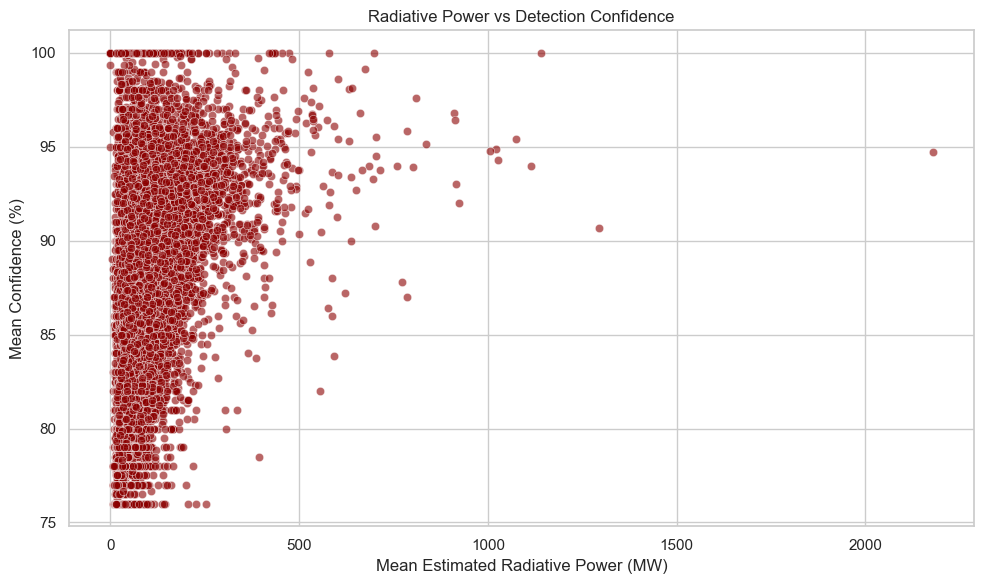

In [39]:
plt.figure(figsize=(10, 6))
sns.scatterplot(
    data=df,
    x='Mean_estimated_fire_radiative_power',
    y='Mean_confidence',
    alpha=0.6,
    color='darkred',
    edgecolor='white'
)
plt.title('Radiative Power vs Detection Confidence')
plt.xlabel('Mean Estimated Radiative Power (MW)')
plt.ylabel('Mean Confidence (%)')
plt.grid(True)
plt.tight_layout()
plt.show()


Most fire events in the dataset had relatively low radiative power but were still detected with high confidence. The plot shows a dense cluster of small-to-moderate fires in the upper-left region, indicating that even less intense fires were reliably identified. A few rare, high-power fires appear further to the right — these were also detected with strong confidence, suggesting the satellite system performs consistently across different fire intensities.


### Distribution of Estimated Fire Brightness by Region

This plot compares the distribution of mean fire brightness across regions. It helps reveal whether certain regions experience consistently more intense fires, or if brightness levels are more evenly spread.

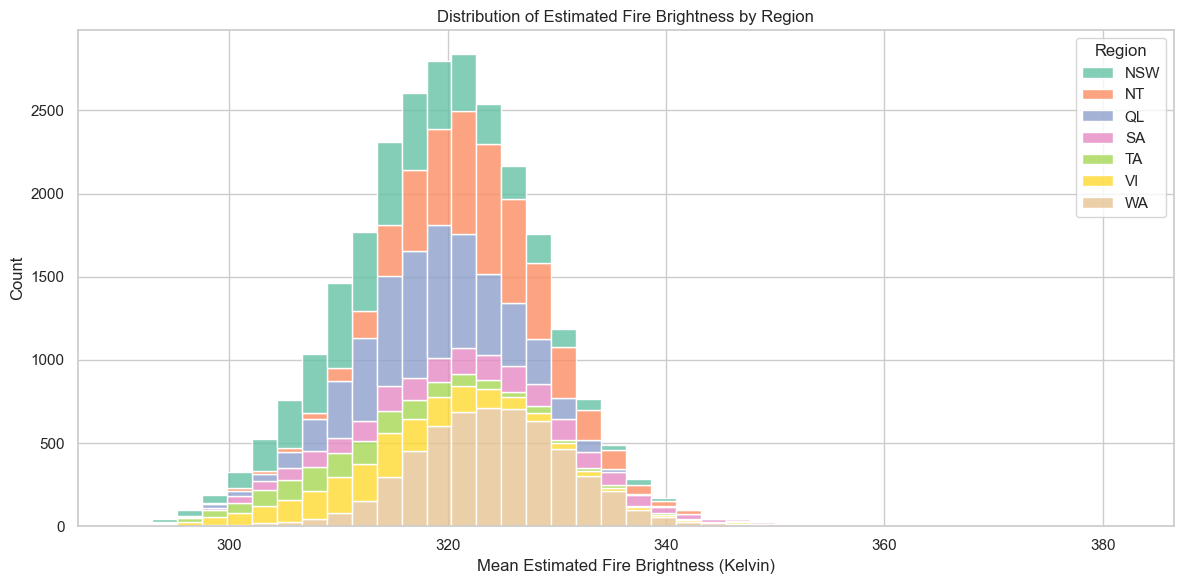

In [47]:
plt.figure(figsize=(12, 6))
sns.histplot(
    data=df,
    x='Mean_estimated_fire_brightness',
    hue='Region',
    multiple='stack',     # Try 'dodge' or 'layer' as alt styles
    palette='Set2',
    alpha=0.8,
    edgecolor='white',
    bins=40
)
plt.title('Distribution of Estimated Fire Brightness by Region')
plt.xlabel('Mean Estimated Fire Brightness (Kelvin)')
plt.ylabel('Count')
plt.grid(True)
plt.tight_layout()
plt.show()


This stacked histogram shows how fire brightness is distributed across regions. The x-axis represents the estimated fire brightness (in Kelvin), while the y-axis shows how many fires fell into each brightness range. Each bar is color-coded by region, allowing us to see not just how frequent different fire intensities were, but which regions contributed to those intensities.

Most fires across all regions fall between 310K and 330K, with Queensland, Western Australia, and the Northern Territory accounting for a large portion of high-brightness events.


### Average Fire Brightness by Region

While the histogram showed how brightness levels are distributed within each region, the bar chart below summarizes the average brightness observed in each region. This helps identify regions that tend to experience more intense fires overall.


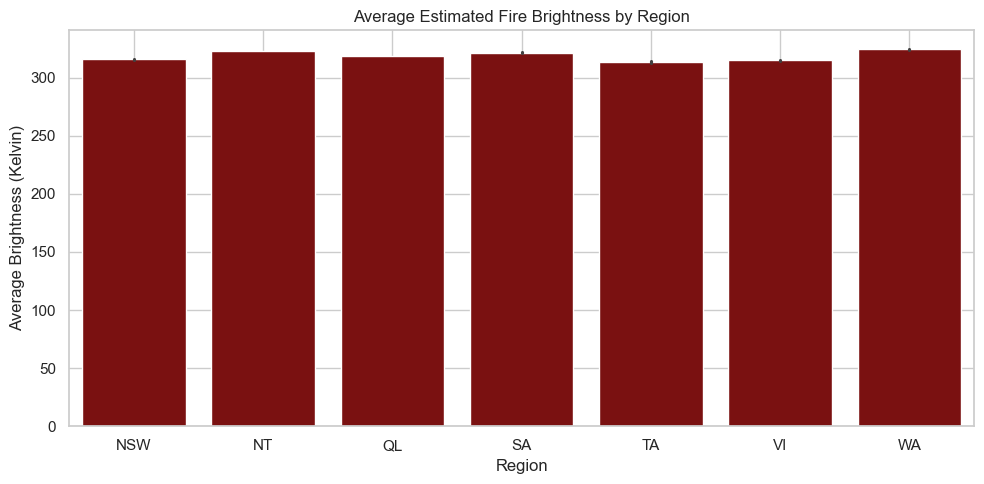

In [50]:
plt.figure(figsize=(10, 5))
sns.barplot(
    data=df,
    x='Region',
    y='Mean_estimated_fire_brightness',
    estimator='mean',
    color='darkred'
)
plt.title('Average Estimated Fire Brightness by Region')
plt.xlabel('Region')
plt.ylabel('Average Brightness (Kelvin)')
plt.grid(True)
plt.tight_layout()
plt.show()


Average fire brightness values are relatively consistent across regions, with slight variations. Regions like the Northern Territory and Western Australia show marginally higher mean brightness, suggesting they may experience slightly more intense fire events on average.


## Results & Key Insights

This notebook provided a detailed exploration of wildfire activity across Australian regions using geospatial and temporal analysis. Key observations include:

- Wildfire activity peaked in 2012, with periodic surges observed in other years.
- Fire activity intensifies seasonally between August and November.
- The Northern Territory and Western Australia accounted for the majority of detected fire pixels.
- Most fires fell within a moderate brightness range (310K–330K), though regional contributions varied.
- Despite regional differences in frequency and scale, detection confidence remained consistently high.

These insights lay the foundation for the interactive dashboard, where users can further explore spatial and temporal fire patterns through dynamic visualizations.

View the interactive dashboard: [Wildfire Dashboard (Dash App)](../app/wildfire_dashboard.py)

---

For dataset, environment setup, and additional project notes, see the README.

This project is part of a broader portfolio showcasing practical applications of data science across analytics, visualization, and machine learning. For more projects, visit [My GitHub Portfolio](https://github.com/J1111-dotcom).
